Gather Imports
----------------------------

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import date, datetime
import math
import time
from ipywidgets import widgets
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tools.eval_measures import rmse
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import metrics, optimizers, losses
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
!pip install dateparser
import dateparser

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 288 kB 5.7 MB/s 


Load the Data
----------------------------

In [2]:
# For devlopement only

# from google.colab import drive
# drive.mount('/content/gdrive')
# filepath = '/content/gdrive/My Drive/oilprices.csv'


# Production file paths

filepath = '/content/oilprices.csv' 
df = pd.read_csv(filepath)

Split the Data
----------------------------

In [4]:
# Split data for test and train

# first 70% for test, last 30% for train
train_data, test_data = df[0:int(len(df) * 0.7)], df[int(len(df) * 0.7):]

# Convert df to numpy arrays 
training_data = train_data['Price'].values
testing_data = test_data['Price'].values

training_data, testing_data = training_data.reshape(-1, 1), testing_data.reshape(-1, 1)

Descriptive Section
----------------------------

In [26]:
# Standard Deviation for full data set calcualted 2 ways 

'''
Standard Deviation measures how dispersed the values are from the mean value.
A large standard deviation versus the mean could indicate that the data set will
perform poorly for prediction because values are too dispersed.
Standard deviation is then compared to the mean of the data set. 
'''

# via numpy
s_dev_np = np.std(df['Price']) 

# manually
mean = np.mean(df['Price'])

temp_list = []

for i in df['Price']:
    x = i - mean
    y = x * x
    temp_list.append(y)

var = np.mean(temp_list)
s_dev_manual = math.sqrt(var)

# Output
print("Numpy's Std Dev is:   ",  round(s_dev_np, 3))
print("My Manual Std Dev is: ",  round(s_dev_manual, 3))
print("Delta: ", s_dev_np - s_dev_manual)

# Evaluation of Std Dev
avg = sum(df['Price']) / len(df['Price'])
print("\n\nMean:       ", round(s_dev_manual, 3))
print("Std Dev:    ", round(avg, 3))
eval = (s_dev_manual - avg) / avg
print("Evaluation: ", abs(round(eval, 3)))


Numpy's Std Dev is:    32.163
My Manual Std Dev is:  32.163
Delta:  -4.263256414560601e-14


Mean:        32.163
Std Dev:     46.353
Evaluation:  0.306


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[]

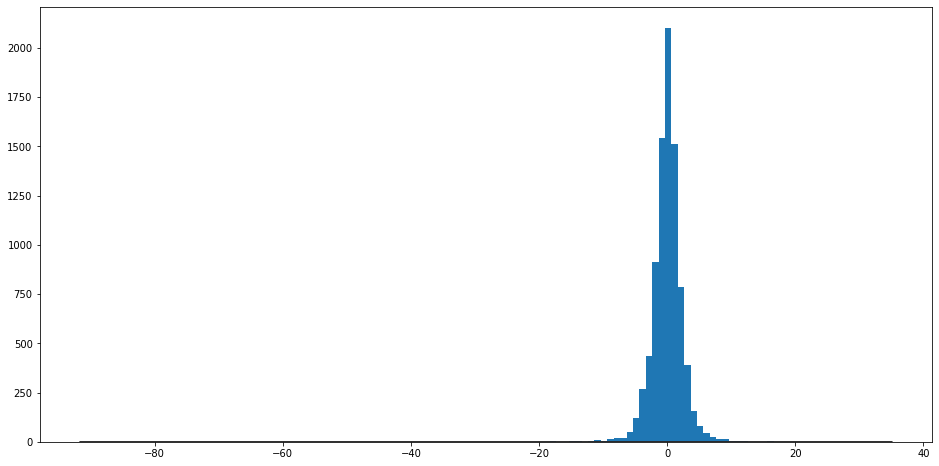

In [6]:
# Histogram based on % change between values

'''
As shown by the plot, most values are within the +10% or -10% change 
with some extreme changes of -92% and +37%. 
This illustrates the wide variance within the data
-particularly the drops in price from 2008 & 2009.
'''


change_list = []

for i in range(len(df['Price'])):
  if i != 0:
    delta = (df['Price'][i] - df['Price'][i-1])/df['Price'][i]
    change_list.append(delta * 100)

fig, ax = plt.subplots(figsize=(16,8))

plt.hist(change_list, bins=np.arange(min(change_list), max(change_list) + 1, 1))


ax = sns.distplot(change_list,fit=norm, kde=False, hist=True, color='r')
ax.plot()


Test Corrolation Vector
Average Corrolation: 0.994894346148506

[0.99019337 0.99088122 0.99153527 0.99217687 0.99280369 0.99343194
 0.99406462 0.99468278 0.99530821 0.99593505 0.99661211 0.99728507
 0.99796399 0.9986497  0.99933849 1.         0.99933849 0.9986497
 0.99796399 0.99728507 0.99661211 0.99593505 0.99530821 0.99468278
 0.99406462 0.99343194 0.99280369 0.99217687 0.99153527 0.99088122
 0.99019337]


Training Corrolation Vector
Average Corrolation: 0.9961147852008113

[0.99229892 0.99283439 0.99336478 0.99389771 0.99443517 0.99497175
 0.99551695 0.99605051 0.99656868 0.99707968 0.99757172 0.99806626
 0.99855758 0.99904297 0.99952211 1.         0.99952211 0.99904297
 0.99855758 0.99806626 0.99757172 0.99707968 0.99656868 0.99605051
 0.99551695 0.99497175 0.99443517 0.99389771 0.99336478 0.99283439
 0.99229892]






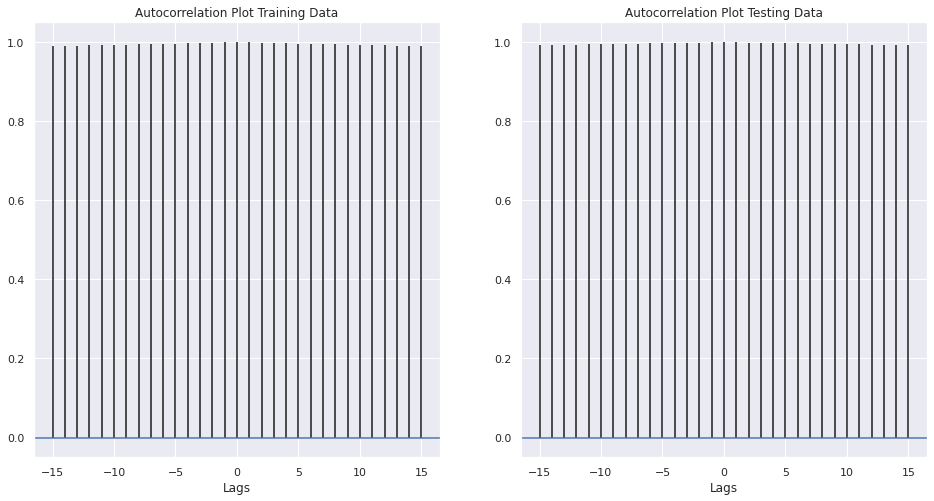

In [34]:
# Autocorrolation Metrics

'''
This data set--for test and train--is highly autocorrelative. 
High Autocorrolation means the future values can be derived from past state
'''    

# Reshape for processing
f_train = training_data.flatten()
f_test = testing_data.flatten()

# Define plot
plt.figure(figsize=(16, 8))

# Autocorrolation for Train data
plt.subplot(1, 2, 1)
plt.title("Autocorrelation Plot Training Data") 
plt.xlabel("Lags") 
test_cor_vx = plt.acorr(f_train, maxlags = 15) 

# Autocorrolation for Test data
plt.subplot(1, 2, 2)
plt.title("Autocorrelation Plot Testing Data") 
plt.xlabel("Lags") 
train_cor_vx = plt.acorr(f_test, maxlags = 15) 

print("Test Corrolation Vector")
avg = avg = sum(test_cor_vx[1])/len(test_cor_vx[1])
print("Average Corrolation: " + str(avg) + "\n")
print(test_cor_vx[1])

print("\n\nTraining Corrolation Vector")
avg = avg = sum(train_cor_vx[1])/len(train_cor_vx[1])
print("Average Corrolation: " + str(avg) + "\n")
print(train_cor_vx[1])
print("\n\n\n")

sns.set_theme()
plt.show() 

Prepare the Data for Processing
----------------------------

In [8]:
# Transform the data for processing

'''
This LSTM Nerual network reqires inputs to be between 0 and 1. 
Scaling is frequently done using sigmoid or tanh
'''

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(training_data)
scaled_test_data = scaler.fit_transform(testing_data)

Configure and Train the LSTM Neural Network
----------------------------

In [9]:
## Time Tracking 
# --------------


# 1. Total model compilation, training, prediction time
start_time = time.time()

# 2. To Track training time history per epoch

class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()



## Configure the Model Params
# --------------------------

'''
Model views a rolling five-day window for a single feature. 
The model has 30 hidden layers of deep learning
with a single final layer  prediction node.
Epochs = 10
'''

timestep = 5 # Rolling 5 day
features = 1 # only 1 features: Price of the oil
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=timestep, batch_size=1)


lstm_model = Sequential()
lstm_model.add(LSTM(30, input_shape=(timestep, features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')


# Train the Model
# ---------------

history = lstm_model.fit(generator, epochs=10, callbacks=[time_callback])


# Use the LSTM model to predict future states
# -------------------------------------------

lstm_predictions_scaled = list()

batch = scaled_test_data[:timestep]
current_batch = batch.reshape((1, timestep, features))

# Iterate over each date in the test data to predict future value
for i in range(len(testing_data) - 5):
  
    lstm_pred = lstm_model.predict(current_batch)[0] # predict 
    lstm_predictions_scaled.append(lstm_pred) # save predictions

    # Change rolling window
    current_batch = np.append(current_batch[:, 1:, :], [[scaled_test_data[i+5]]], axis=1)



lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
test_time = np.arange(start=0, stop=testing_data.size - 5)


# Time Metrics
times = time_callback.times # 2. epoch times
program_time = time.time() - start_time # 1. total time

print("2. Avg Seconds per Epoch: " + str(np.average(times)))
print("1. Total Program Seconds: " + str(program_time))


Epoch 1/10
5982/5982 [==============================] - 27s 4ms/step - loss: 7.2915e-04
Epoch 2/10
5982/5982 [==============================] - 25s 4ms/step - loss: 1.7094e-04
Epoch 3/10
5982/5982 [==============================] - 25s 4ms/step - loss: 1.2441e-04
Epoch 4/10
5982/5982 [==============================] - 25s 4ms/step - loss: 9.3716e-05
Epoch 5/10
5982/5982 [==============================] - 25s 4ms/step - loss: 8.8639e-05
Epoch 6/10
5982/5982 [==============================] - 25s 4ms/step - loss: 8.1597e-05
Epoch 7/10
5982/5982 [==============================] - 25s 4ms/step - loss: 7.8135e-05
Epoch 8/10
5982/5982 [==============================] - 25s 4ms/step - loss: 7.5886e-05
Epoch 9/10
5982/5982 [==============================] - 25s 4ms/step - loss: 7.5411e-05
Epoch 10/10
5982/5982 [==============================] - 25s 4ms/step - loss: 7.5989e-05
2. Avg Seconds per Epoch: 25.047236728668214
1. Total Program Seconds: 473.79560136795044


In [27]:
# Trained Model Accuracy on training data

'''
https://keras.io/getting_started/faq/#why-is-my-training-loss-much-higher-than-my-testing-loss
Besides, the training loss that Keras displays is the average of the losses
for each batch of training data, over the current epoch. 
This can bring the epoch-wise average down. On the other hand, 
the testing loss for an epoch is computed using the model 
as it is at the end of the epoch, resulting in a lower loss.
'''

score = lstm_model.evaluate(generator, batch_size=3, verbose=1)
print('Train accuracy: ', score)

5982/5982 [==============================] - 12s 2ms/step - loss: 6.4347e-05
Train accuracy:  6.43470193608664e-05


Visualization Section
----------------------------

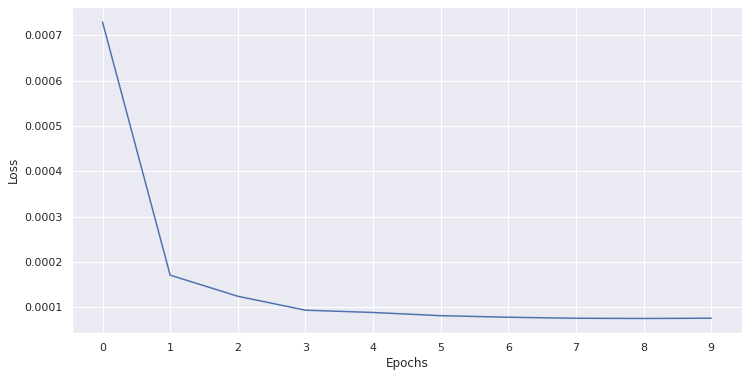

In [35]:
# Viz 1: Plot the loss of the LSTM Neural Network over each epoch

losses_lstm = history.history['loss']
plt.figure(figsize=(12, 6))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0, 21, 1))
plt.plot(range(len(losses_lstm)), losses_lstm)
sns.set_theme()
plt.show()

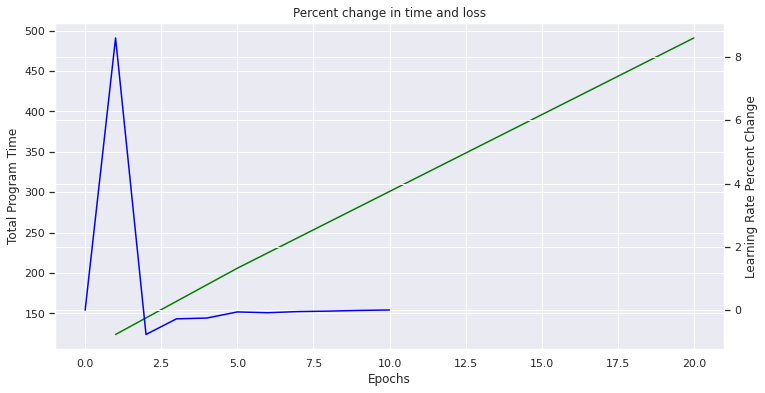

In [36]:
# Viz 2: Plot the loss per epoch vs total processing time


# Manually Recorded Total processing times
processing_times = ((1, 124),
                    (5, 206), 
                    (10, 301),
                    (20, 491))

# data prep - splitting the data
epochs, total_program_time = zip(*processing_times)
  
# Calc % change in loss per epoch
loss_perc_change = []
for i in range(len(losses_lstm)):
  if i == 0:
    loss_perc_change.append(0)
  t = (losses_lstm[i] - losses_lstm[i-1]) / losses_lstm[i-1]
  loss_perc_change.append(t)


plt.figure(figsize=(12, 6))
plt.xlabel("Epochs")
plt.ylabel("Total Program Time")
plt.plot(epochs, total_program_time, color='green')

plt.twinx()

plt.ylabel("Learning Rate Percent Change")
plt.plot(range(len(loss_perc_change)), loss_perc_change, color='blue')
plt.title("Percent change in time and loss")

sns.set_theme()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


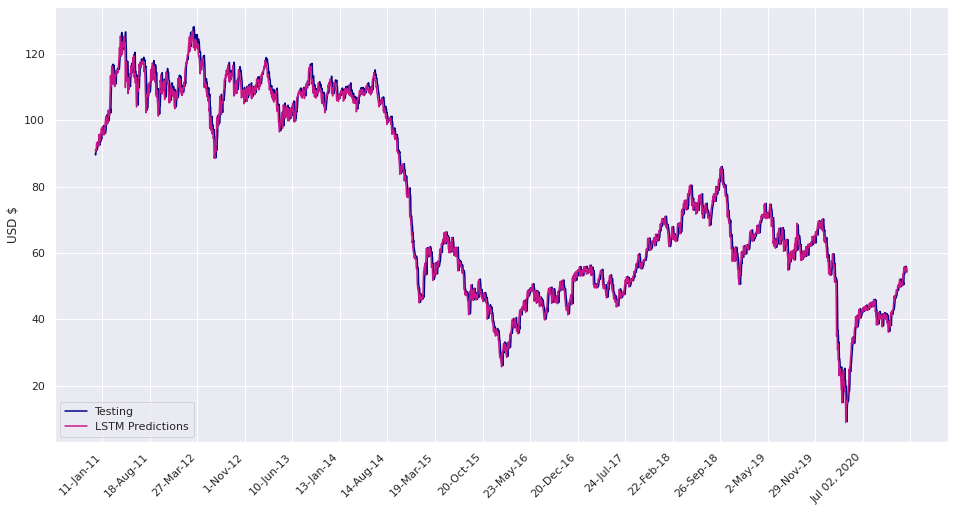

In [33]:
# Viz 3: Plot testing values vs LSTM predictions

train_viz = df[0:int(len(df) * 0.7)]
test_viz = df[int(len(df) * 0.7):-5]
test_viz['LSTM'] = lstm_predictions 

fig, ax = plt.subplots(figsize=(16,8))
plt.plot(test_viz['Date'], test_viz['Price'], 'darkblue')
plt.plot(test_viz['Date'], test_viz['LSTM'], 'mediumvioletred')
ax.set_ylabel("USD $")
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 150))
plt.xticks(rotation=45, ha="right")
plt.legend(['Testing', 'LSTM Predictions'], loc='lower left')
sns.set_theme()
plt.show()


In [31]:
# Root Mean Square Error (RSME) of the LSTM

'''
RSME is a huristic for predictive models
The RSME is acceptable relative to the variance in the data
'''

lstm_rmse_error = rmse(test_viz['Price'], test_viz['LSTM'])
print(f'RMSE Error: {lstm_rmse_error}\nVariance: {var}')

eval = lstm_rmse_error/var

if eval < .05:
  print(f'\nMetric SUCCESS: {eval}')
else:
  print(f'Metric FAIL ')


RMSE Error: 2.830797871665306
Variance: 1034.4844404411829

Metric SUCCESS: 0.0027364334938261986


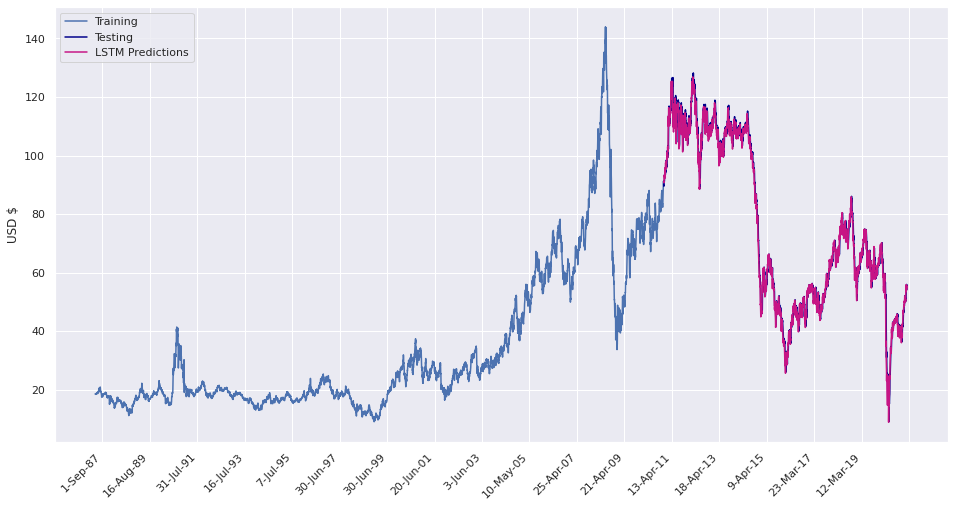

In [32]:
# Viz 4: Plot of training, test, and LSTM prediction values 

fig, ax = plt.subplots(figsize=(16,8))
plt.plot(train_viz['Date'],train_viz['Price'])
plt.plot(test_viz['Date'], test_viz['Price'], 'darkblue')
plt.plot(test_viz['Date'], test_viz['LSTM'], 'mediumvioletred')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 500))
ax.set_ylabel("USD $")
plt.xticks(rotation=45, ha="right")
plt.legend(['Training', 'Testing', 'LSTM Predictions'], loc='upper left')
sns.set_theme()
plt.show()




Interactive Section
----------------------------

In [37]:
# Set Model Prediction Accuracy Level

def define_accuracy():
  acc_metric = input("Please enter a whole number (1% - 100%) accuracy threshold: ")
  
  if int(acc_metric) < 1 or int(acc_metric) > 100:
    print("Must be between 1 and 100")
    define_accuracy()
  
  return acc_metric

acc_metric = int(define_accuracy())


# Does the LSTM model achieve the acceptace standards defined by the user?

goal_acc = 100 - acc_metric

if goal_acc >= lstm_rmse_error:
  print("\n\nSUCCESS!")
  marg = goal_acc - lstm_rmse_error
  print("LSTM Error Level:    " + str(lstm_rmse_error)
    + "\nAcceptace Standard : " + str(goal_acc))
else:
  print("\n\nFAIL")
  print("LSTM Error Level:   " + str(lstm_rmse_error)
    + "\nAcceptace Standard: " + str(goal_acc))


Please enter a whole number (1% - 100%) accuracy threshold: 67


SUCCESS!
LSTM Error Level:    2.830797871665306
Acceptace Standard : 33


In [40]:
# Prep Code

test_timeline = test_data['Date'].values

for i in range(len(test_timeline)):
  test_timeline[i] = dateparser.parse(test_timeline[i])

test_start = test_timeline[0]
test_end = test_timeline[-1]


def display_metrics(input_date):
  if test_start <= input_date <= test_end:
  
    # get index of date
    d_index = np.where(test_timeline == my_dt)[0]
    d_index = d_index[0]

    # get LSTM prediction & actual value with index
    p_val = lstm_predictions[d_index]
    a_val = testing_data[d_index]

    # compare: % delta
    delta = ((p_val - a_val) /a_val)
    print("LSTM Prediction: " + str(p_val))
    print("Actual Value:    " + str(a_val))
    print("Delta Percent:   " + str(delta))
    foo = [p_val[0], a_val[0] ]
    plt.boxplot( [foo] )
    plt.show()

    
  else:
    print("Error \nDate must be between the test data start and end")
    print("Selection: " + str(input_date))
    print("Test Start: " + str(test_start))
    print("Test End: " + str(test_end))



w = widgets.DatePicker(
    description='Pick a Date',
    disabled=False,
)

display(w)


DatePicker(value=None, description='Pick a Date')

LSTM Prediction: [43.45923638]
Actual Value:    [44.92]
Delta Percent:   [-0.03251923]


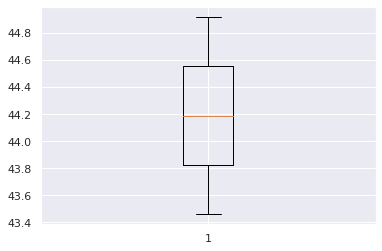

In [41]:
# Check deltas for individual dates

my_dt = datetime.combine(w.value, datetime.min.time())

display_metrics(my_dt)

